# Stock Exchange Example

## Install Requirements

In [20]:
!pip install --quiet agent-exchange==0.0.5 pandas numpy matplotlib seaborn

In [125]:
from random import shuffle, random, randint
from typing import Sequence, Tuple, Dict, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from agent_exchange.agent import Agent
from agent_exchange.exchange import Exchange

from stock_exchange_v1 import * # requires stock_exchange_v1.py file to be local
from stock_agent_v1 import *    # requires stock_agent_v1.py file to be local

In [145]:
%matplotlib inline

## Make Stock Exchange Agents

## Market Maker
A market maker provides liquidity to the market by placing limit orders. Here we implement a naive market maker that randomly places bid and asks, but always places them just inside the spread.

In [261]:
class StockAgentV1NaiveMaker(StockAgentV1):
    """Naive agent that acts as a market maker.
    If there is a spread, this agent will place
    an order on the buy side 1/2 of the time, on
    the sell side 1/2 of the time.

    Note: in V1, there is no way to place multiple
    orders within the same time step.
    """
    def __init__(self, initial_num_shares=1000, initial_capital=100000, max_margin=1000):
        self.max_margin = max_margin
        super().__init__(initial_num_shares, initial_capital)

    def get_action(self, order_book: StockExchangeV1OrderBook):
        if random() < .5: # buy just over current bid
            buy_price = order_book.get_bid() + 0.01 # penny-up on the market-clearing buy price
            
            # Randomly buy as little as 0 or as much as 100
            buy_amount = randint(0, 1000) # limit buy

            order = StockExchangeV1Action(StockExchangeV1OrderTypes.LIMIT, buy_amount, buy_price)

            return order
        else: # sell just under current ask
            sell_price = order_book.get_ask() - 0.01

            # Randomly sell as little as 0 and as much as 10
            sell_amount = randint(0, 1000)

            order = StockExchangeV1Action(StockExchangeV1OrderTypes.LIMIT, -sell_amount, sell_price)

            return order

## Market _taker_
A taker is a market participant that takes liquidity by placing market orders. Here we implement a naive market taker who buys and sells at random.

In [205]:
class StockAgentV1NaiveTaker(StockAgentV1):
    """Naive agent that acts as a liquidity
    taker. This agent speculates by placing
    market orders of buy 1/2 of the time and
    sell 1/2 of the time. Here we ignore
    constraints on short selling, allowing
    agents to shorts sell without limit.

    Also, if the taker's order exhausts the
    order book, then only the portion of their
    order in the order book gets filled.
    """
    def __init__(self, initial_num_shares=1000, initial_capital=100000):
        super().__init__(initial_num_shares, initial_capital)

    def get_action(self, order_book: StockExchangeV1OrderBook):
        if random() < .5: # buy
            expected_buy_price = order_book.get_ask()
            
            # Randomly decide on how much to buy
            max_buy_amount = self.internal_state.get_capital() // expected_buy_price
            max_buy_amount = max(max_buy_amount, 0)
            num_shares_to_buy = randint(0, max_buy_amount)

            return StockExchangeV1Action(StockExchangeV1OrderTypes.MARKET, num_shares_to_buy)

        else:
            expected_sell_price = order_book.get_bid()

            # Randomly decide on how much to sell
            max_sell_amount = max(0, self.internal_state.get_num_shares())
            num_shares_to_sell = randint(0, max_sell_amount)

            return StockExchangeV1Action(StockExchangeV1OrderTypes.MARKET, -num_shares_to_sell)

## Run simulations
Now that we have made a market maker and a market taker, we can run a simulation with them!

In [216]:
def portfolio_values(ex: StockExchangeV1, ag: StockAgentV1):
    """Value of the agent over time; helps to get visualize agents' values
    """
    
    shares_over_time, capital_over_time = ag.internal_state.num_shares, ag.internal_state.capital
    bids, asks = ex.get_bids(), ex.get_asks()
    estimated_prices = [(bid + ask)/2 for bid, ask in zip(bids, asks)] # estimate price as midpoint between bid and ask

    values = []
    for shares, capital, estd_price in zip(shares_over_time, capital_over_time, estimated_prices):
        values.append(shares*estd_price + capital)
    return values

def run_naive_experiment(num_makers, num_takers, num_steps, verbose=True):
    INITIAL_N_SHARES, INITIAL_CAPITAL, INITIAL_PRICE = 1000, 100000, 100
    initial_value = INITIAL_PRICE * INITIAL_N_SHARES + INITIAL_CAPITAL
    
    agents = [StockAgentV1NaiveMaker(INITIAL_N_SHARES, INITIAL_CAPITAL) for _ in range(num_makers)]
    agents += [StockAgentV1NaiveTaker(INITIAL_N_SHARES, INITIAL_CAPITAL) for _ in range(num_takers)]
    exchange = StockExchangeV1(agents)

    exchange.simulate_steps(num_steps)
    
    
    # Put portfolio data together
    all_portfolio_values = pd.DataFrame()
    for i, agent in enumerate(agents):
        all_portfolio_values[i] = portfolio_values(exchange, agent)
        
    maker_indices = set(all_portfolio_values.columns[:num_makers])
    taker_indices = set(all_portfolio_values.columns) - maker_indices
    
    maker_portfolio_values = all_portfolio_values[maker_indices]
    taker_portfolio_values = all_portfolio_values[taker_indices]
    
    # Get overall returns
    maker_final_value = maker_portfolio_values.iloc[-1]
    taker_final_value = taker_portfolio_values.iloc[-1]
    
    avg_maker_profit = sum(maker_final_value)/len(maker_final_value) - initial_value
    avg_taker_profit = sum(taker_final_value)/len(taker_final_value) - initial_value
    
    avg_maker_return = avg_maker_profit / initial_value
    avg_taker_return = avg_taker_profit / initial_value
    
    # Visualize market price fluctuations
    if verbose:
        plt.style.use('seaborn-colorblind')
        w, h = 20, 10
        matplotlib.rcParams['figure.figsize'] = [w, h]

        _, ((ax1, ax2), (ax3, _)) = plt.subplots(nrows=2, ncols=2, sharex=True)

        exchange_sim_data = pd.DataFrame()
        exchange_sim_data['bids'] = exchange.get_bids()
        exchange_sim_data['asks'] = exchange.get_asks()

        sns.lineplot(data=exchange_sim_data, ax=ax1)
        ax1.set_title("Market prices")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Price ($)")


        ## Maker portfolio values
        sns.lineplot(data=maker_portfolio_values.head(num_steps), ax=ax2, legend=False)
        ax2.set_title("Maker Value vs. Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Value ($)")
        print(f"Maker stats:\n{maker_final_value.describe()}")


        ## Taker portfolio values
        sns.lineplot(data=taker_portfolio_values.head(num_steps), ax=ax3, legend=False)
        ax3.set_title("Taker Value vs. Iteration")
        ax3.set_xlabel("Iteration")
        ax3.set_ylabel("Value ($)")  
        print(f"Taker stats:\n{taker_final_value.describe()}")
        
    return avg_maker_return, avg_taker_return

In [217]:
m_ret, t_ret = run_naive_experiment(num_makers=10, num_takers=10, num_steps=30, verbose=False)
m_ret, t_ret

(0.0007252149999995891, -0.0008752149999998801)

In [224]:
n_iterations = 10
maker_range = range(1, 8)
taker_range = range(1, 8)

maker_returns = pd.DataFrame(index=maker_range, columns=taker_range)
taker_returns = pd.DataFrame(index=maker_range, columns=taker_range)
for n_makers in maker_range:
    for n_takers in taker_range:
        maker_return, taker_return = run_naive_experiment(num_makers=10, num_takers=10, num_steps=30,verbose=False)
        maker_returns.loc[n_makers][n_takers] = maker_return
        taker_returns.loc[n_makers][n_takers] = taker_return
        print(f"Done with ({n_makers}, {n_takers})")

Done with (1, 1)
Done with (1, 2)
Done with (1, 3)
Done with (1, 4)
Done with (1, 5)
Done with (1, 6)
Done with (1, 7)
Done with (2, 1)
Done with (2, 2)
Done with (2, 3)
Done with (2, 4)
Done with (2, 5)
Done with (2, 6)
Done with (2, 7)
Done with (3, 1)
Done with (3, 2)
Done with (3, 3)
Done with (3, 4)
Done with (3, 5)
Done with (3, 6)
Done with (3, 7)
Done with (4, 1)
Done with (4, 2)
Done with (4, 3)
Done with (4, 4)
Done with (4, 5)
Done with (4, 6)
Done with (4, 7)
Done with (5, 1)
Done with (5, 2)
Done with (5, 3)
Done with (5, 4)
Done with (5, 5)
Done with (5, 6)
Done with (5, 7)
Done with (6, 1)
Done with (6, 2)
Done with (6, 3)
Done with (6, 4)
Done with (6, 5)
Done with (6, 6)
Done with (6, 7)
Done with (7, 1)
Done with (7, 2)
Done with (7, 3)
Done with (7, 4)
Done with (7, 5)
Done with (7, 6)
Done with (7, 7)


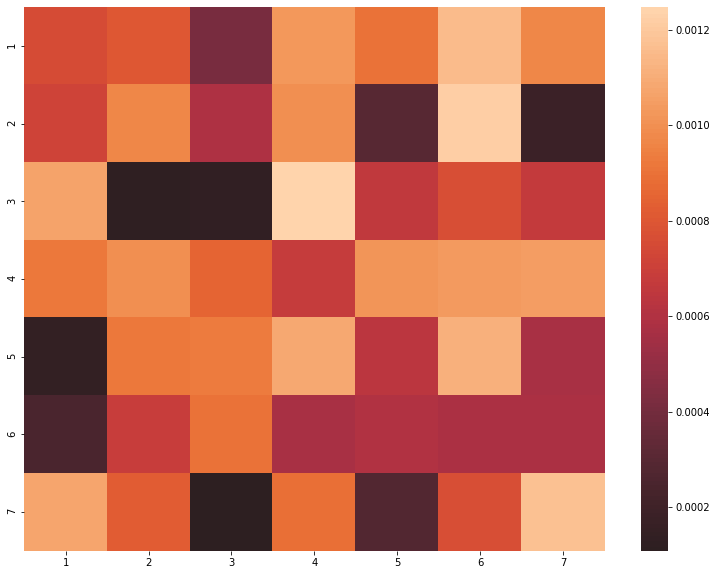

In [259]:
# Maker returns
maker_returns.fillna(value=np.nan, inplace=True)
matplotlib.rcParams['figure.figsize'] = [13, 10]
sns.heatmap(maker_returns, center=0);

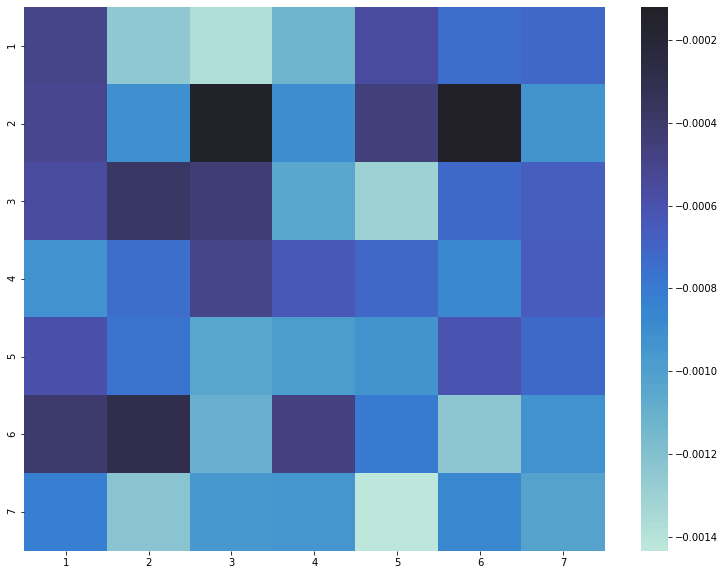

In [260]:
# Taker returns
taker_returns.fillna(value=np.nan, inplace=True)
sns.heatmap(taker_returns, center=0);

Maker stats:
count         3.000000
mean     201679.515000
std         214.874546
min      201434.430000
25%      201601.502500
50%      201768.575000
75%      201802.057500
max      201835.540000
Name: 99, dtype: float64
Taker stats:
count        10.000000
mean     199476.645500
std         103.933614
min      199316.200000
25%      199395.343750
50%      199503.312500
75%      199548.532500
max      199609.070000
Name: 99, dtype: float64


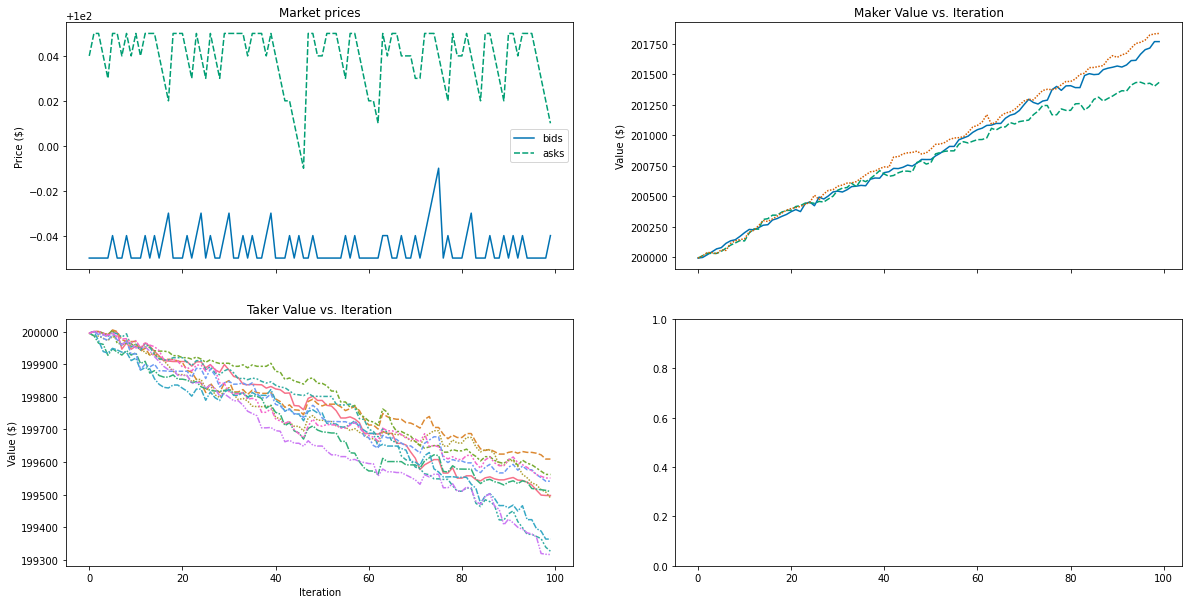

In [262]:
_ = run_naive_experiment(num_makers=3, num_takers=10, num_steps=100)

In [256]:
# _ = run_naive_experiment(num_makers=5, num_takers=10, num_steps=100, num_plot_steps=100)

In [257]:
# _ = run_naive_experiment(num_makers=8, num_takers=10, num_steps=100, num_plot_steps=100)

In [258]:
# _ = run_naive_experiment(num_makers=12, num_takers=8, num_steps=100, num_plot_steps=100)